# System ID with Neural ODEs in NeuroMANCER: LinearSimpleSingleZone



In [1]:
import numpy as np
import sklearn.metrics as metrics
from matplotlib import pyplot as plt

import torch
from torch.utils.data import DataLoader

from neuromancer import psl, blocks
from neuromancer.dynamics import integrators
from neuromancer.modules.activations import SoftExponential
from neuromancer.dataset import DictDataset
from neuromancer.system import Node, System
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.trainer import Trainer
from tqdm.auto import tqdm

from neuromancer.psl import plot

/Users/shap825/anaconda3/envs/neuromancer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
torch.manual_seed(0)

## Generate trajectories

In [41]:
system = psl.systems["LinearSimpleSingleZone"](backend="torch")

In [37]:
raw = system.simulate(nsim=64)

In [38]:
system.ts

0.01

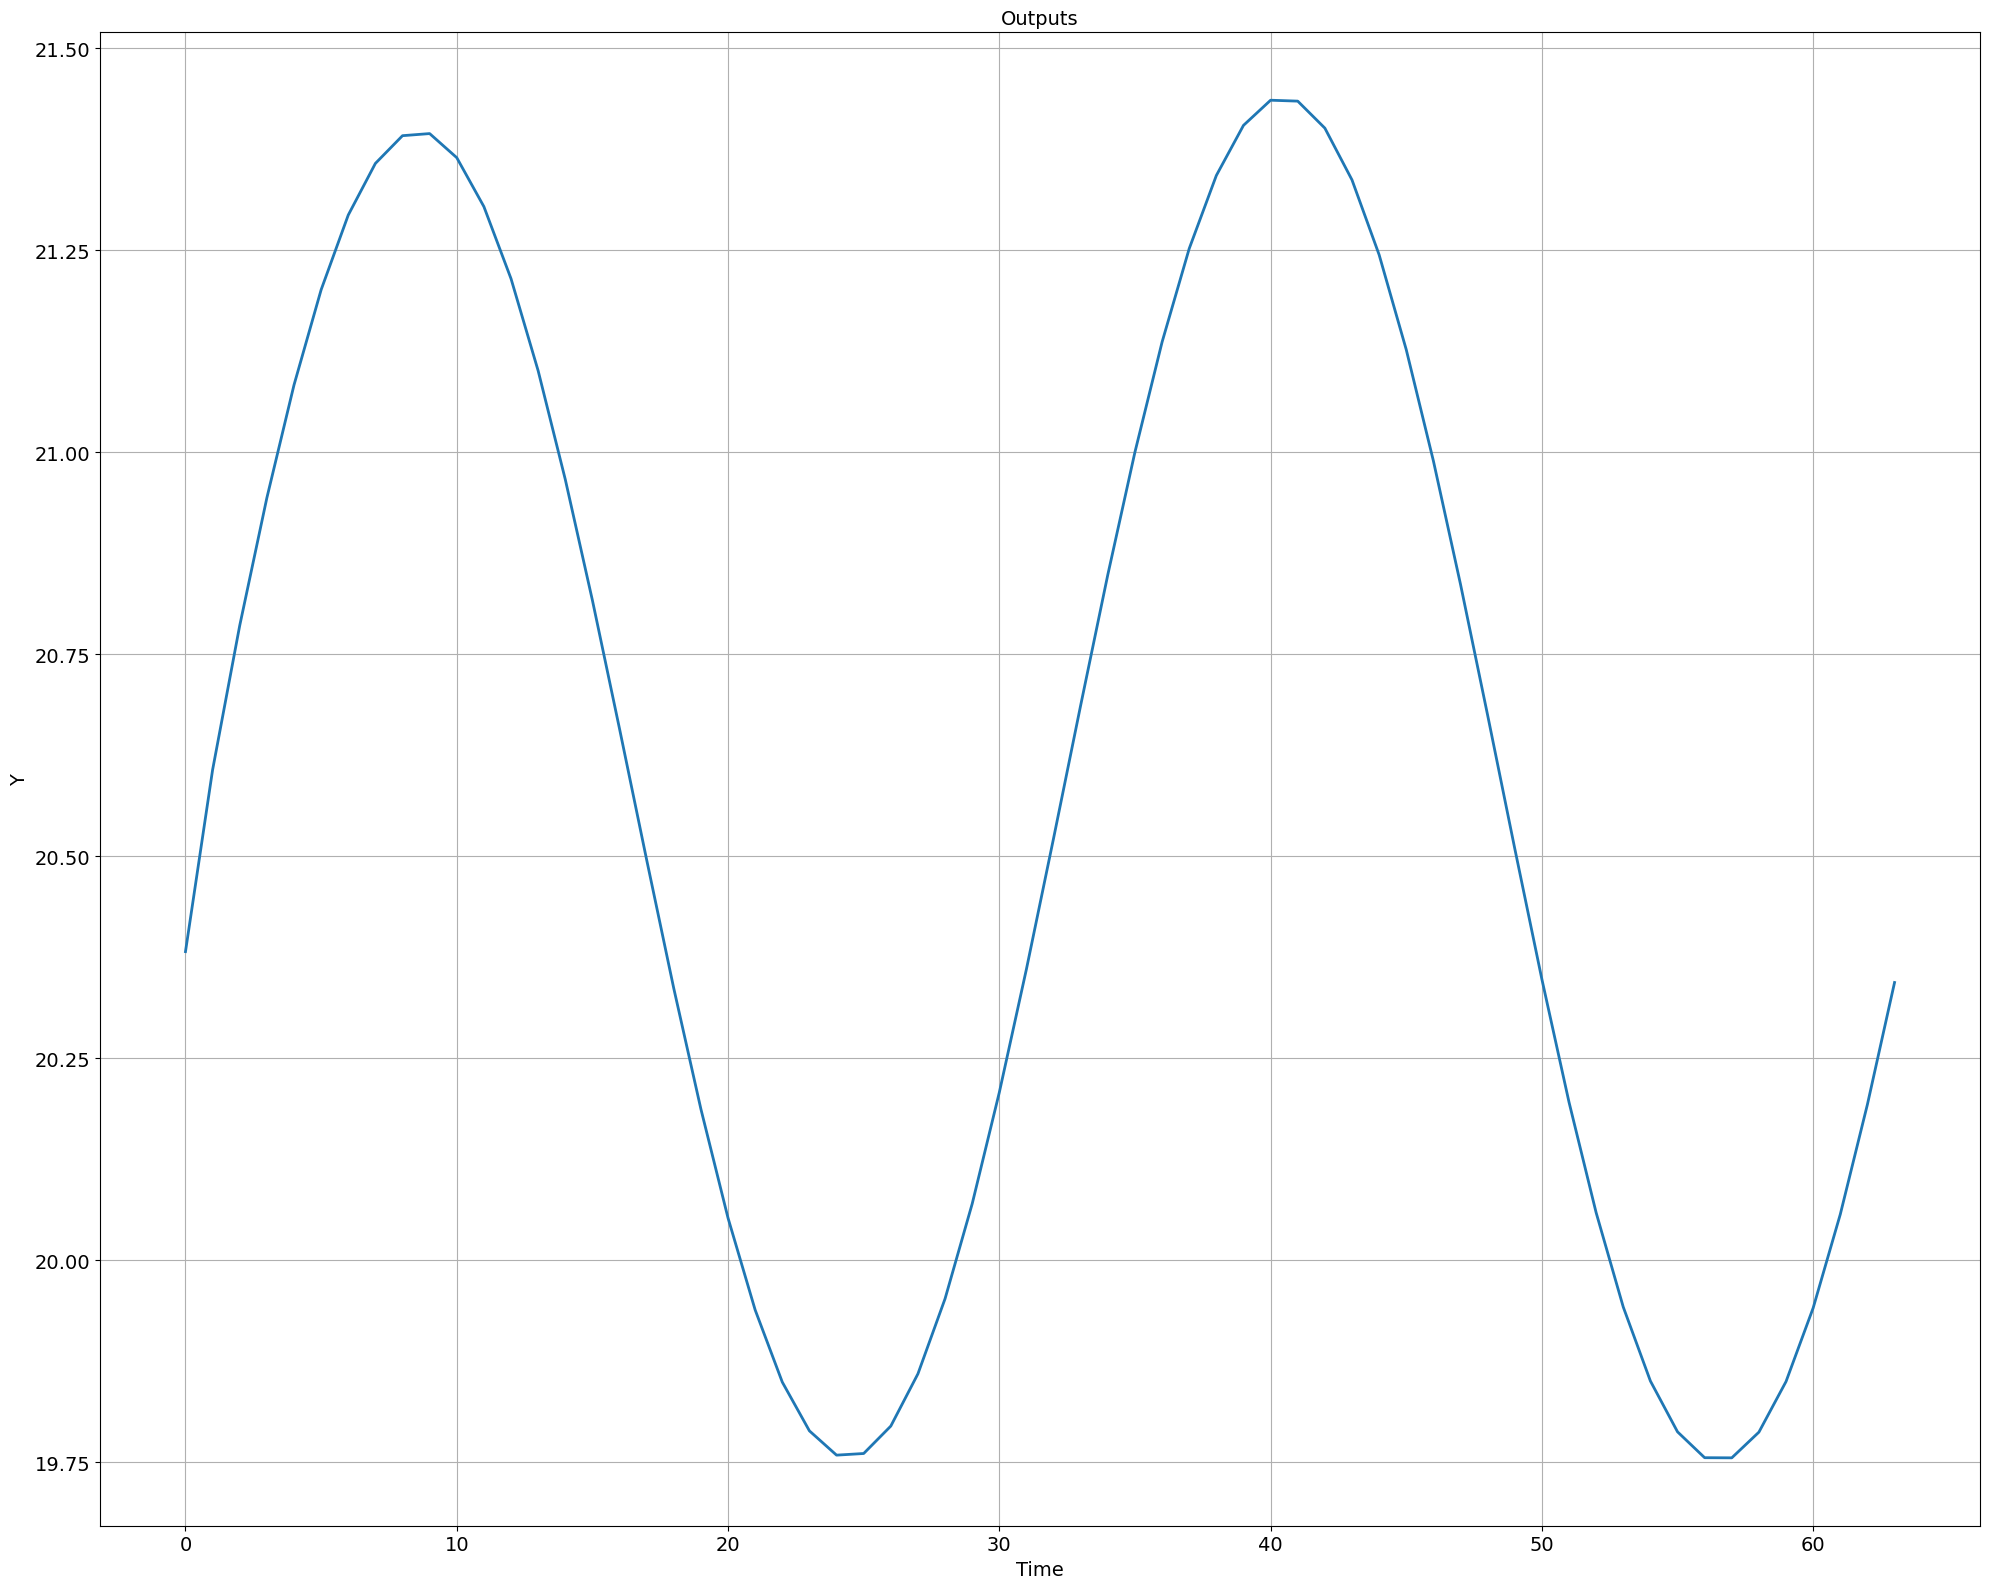

In [39]:
plot.pltOL(Y=raw["Y"])

# Generate datasets

In [4]:
def get_data(sys, nsim, nsteps, signal=None, normalize=True):

    nsim = (nsim // nsteps) * nsteps
    x0 = sys.get_x0()
    U = sys.get_U(nsim+1)
    sim = sys.simulate(nsim=nsim, x0=x0, U=U)
    Y = sys.normalize(sim["Y"], key="Y").reshape(nsim // nsteps, nsteps, sys.ny)
    U = sys.normalize(sim["U"], key="U").reshape(nsim // nsteps, nsteps, sys.nu)
    D = sys.normalize(sim["D"], key="D").reshape(nsim // nsteps, nsteps, sys.nd)




    # for i in tqdm(range(nsim), desc=f"Getting data..."):
    #     x0 = sys.get_x0()
    #     given_U = torch.tensor(sys.get_U(nsteps + 1, signal=signal))
    #     sim = sys.simulate(nsim=nsteps, x0=x0, U=given_U)
    #     Y = torch.tensor(sys.normalize(sim['Y'], key='Y'), dtype=torch.float32)
    #     U = torch.tensor(sys.normalize(sim['U'], key='U'), dtype=torch.float32)
    #     D = torch.tensor(sys.normalize(sim['D'], key='D'), dtype=torch.float32)

    #     given_U = sys.normalize(given_U, key='U')

    #     ylist.append(Y)
    #     ulist.append(given_U[:-1, :])
    #     # ulist.append(U)
    #     dlist.append(D)

    # Y, U, D = torch.stack(ylist), torch.stack(ulist), torch.stack(dlist)
    # ny, nu, nd = Y.shape[-1], U.shape[-1], D.shape[-1]

    return {'Y': Y, 'U': U, 'D': D, 'yn': Y[:, :1]}




In [5]:
def get_dataloader(data, batch_size, name="train", shuffle=True):
    dataset = DictDataset(data, name=name)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        shuffle=shuffle,
    )

In [42]:
nsim = 1000
nsteps = 50

train_data = get_data(system, nsim, nsteps)
dev_data = get_data(system, nsim, nsteps)
test_data = get_data(system, nsim, nsim)

In [43]:
train_loader = get_dataloader(train_data, batch_size=100, name="train")
dev_loader = get_dataloader(dev_data, batch_size=100, name="dev")

In [8]:
system.ny, system.nu, system.nd

(1, 1, 1)

In [44]:
dy = blocks.MLP(
    system.ny + system.nu + system.nd,
    system.ny,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes = [64, 64, 64],
)

In [45]:
dyRK4 = integrators.RK4(dy, h=system.ts)

In [46]:
dynamics_model = System([Node(dyRK4, ["yn", "U", "D"], ["yn"])], nstep_key="Y")

In [47]:
y = variable("Y")
yhat = variable("yn")[:,:-1,:]

# yFD = (y[:, 1:, :] - y[:,:-1,:])
# yhatFD = (yhat[:, 1:, :] - yhat[:,:-1,:])

one_step_loss = (yhat[:,1,:] == y[:,1,:])^2
one_step_loss.name = "onestep_loss"

reference_loss = (yhat == y)^2
reference_loss.name = "ref_loss"

In [48]:
objectives = [reference_loss, one_step_loss]
constraints = []
loss = PenaltyLoss(objectives, constraints)
problem = Problem([dynamics_model], loss)

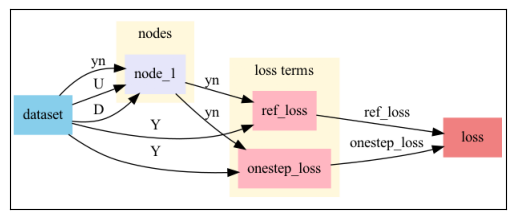

In [49]:
problem.show()

In [50]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)
logger = BasicLogger(
    args=None,
    savedir="test",
    verbosity=1,
    stdout=["dev_loss", "train_loss"],
)

None


In [51]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer,
    logger,
    patience=100,
    warmup=100,
    epochs=1000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss"
)

Number of parameters: 8641


In [52]:
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0	train_loss: 0.18279	dev_loss: 0.20011	eltime:  1.14847
epoch: 1	train_loss: 0.18031	dev_loss: 0.19992	eltime:  1.20300
epoch: 2	train_loss: 0.17810	dev_loss: 0.19972	eltime:  1.25254
epoch: 3	train_loss: 0.17615	dev_loss: 0.19952	eltime:  1.30083
epoch: 4	train_loss: 0.17442	dev_loss: 0.19932	eltime:  1.35524
epoch: 5	train_loss: 0.17289	dev_loss: 0.19910	eltime:  1.40516
epoch: 6	train_loss: 0.17153	dev_loss: 0.19885	eltime:  1.45510
epoch: 7	train_loss: 0.17036	dev_loss: 0.19857	eltime:  1.50448
epoch: 8	train_loss: 0.16936	dev_loss: 0.19826	eltime:  1.55260
epoch: 9	train_loss: 0.16855	dev_loss: 0.19794	eltime:  1.60296
epoch: 10	train_loss: 0.16788	dev_loss: 0.19762	eltime:  1.65414
epoch: 11	train_loss: 0.16731	dev_loss: 0.19732	eltime:  1.70422
epoch: 12	train_loss: 0.16679	dev_loss: 0.19709	eltime:  1.75254
epoch: 13	train_loss: 0.16630	dev_loss: 0.19692	eltime:  1.80092
epoch: 14	train_loss: 0.16580	dev_loss: 0.19684	eltime:  1.85013
epoch: 15	train_loss: 0.16529	dev_l

<All keys matched successfully>

In [53]:
with torch.no_grad():
    test_outputs=dynamics_model(test_data)

In [54]:
for key in test_outputs:
    if key == 'yn':
        test_outputs['yn'] = system.denormalize(test_outputs['yn'], key='Y')
    else:
        test_outputs[key] = system.denormalize(test_outputs[key], key=key)


In [55]:
pred_traj = test_outputs["yn"][:,:-1].detach().numpy()
true_traj = test_outputs["Y"].detach().numpy()

pred_traj = pred_traj.reshape(-1,system.ny)
true_traj = true_traj.reshape(-1,system.ny)

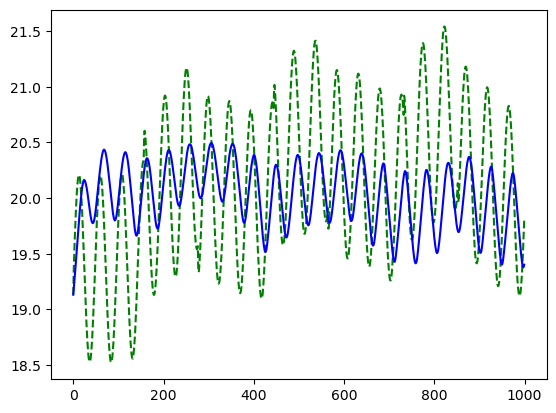

In [56]:
fig, ax = plt.subplots()
ax.plot(true_traj, 'g--')
ax.plot(pred_traj, 'b')

In [57]:
print(metrics.mean_absolute_error(true_traj, pred_traj))
print(metrics.mean_squared_error(true_traj, pred_traj))
print(metrics.r2_score(true_traj, pred_traj))

0.5418169
0.43155867
0.10037396844036672
